# Notebook Details

This notebook contains below sections

1. **ARIMA -** Arima model with manual parameter selection
2. **Auto ARIMA -** Arima model with automatic parameter identification, objective is to minimize AIC
3. **SARIMA -** Seasonal Arima model with automatic parameter identification

# ✅ Common Assumptions for Time Series Forecasting

1. **Time Order Matters**  
   - Data must be in correct chronological order (no shuffling!).

2. **Stationarity (Weak or Strong)**  
   - Statistical properties (mean, variance) should be constant over time.  
   - If not, make it stationary via transformations (differencing, log, etc.).

3. **Seasonality & Trends Should Be Detectable**  
   - Patterns that repeat (e.g., daily, weekly) are often expected.  
   - Trends (upward/downward) should be modeled or removed.

4. **No Missing Timestamps**  
   - The time index should be continuous and consistent (e.g., hourly, daily).  
   - Gaps can break models.

5. **Sufficient Historical Data**  
   - Enough past data points are needed to learn temporal patterns.

6. **Autocorrelation Exists**  
   - Past values should influence future values.  
   - If there's no correlation, time series forecasting may not help.

7. **External Influences Are Known or Constant**  
   - Major external events (e.g., lockdowns, holidays) should be accounted for or assumed to not change.


# ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average — it's a classic statistical model for univariate time series forecasting.
In simple terms, ARIMA tries to model the future value of a variable based on its own past values and past errors.

**Breakdown of ARIMA(p, d, q)** <br>

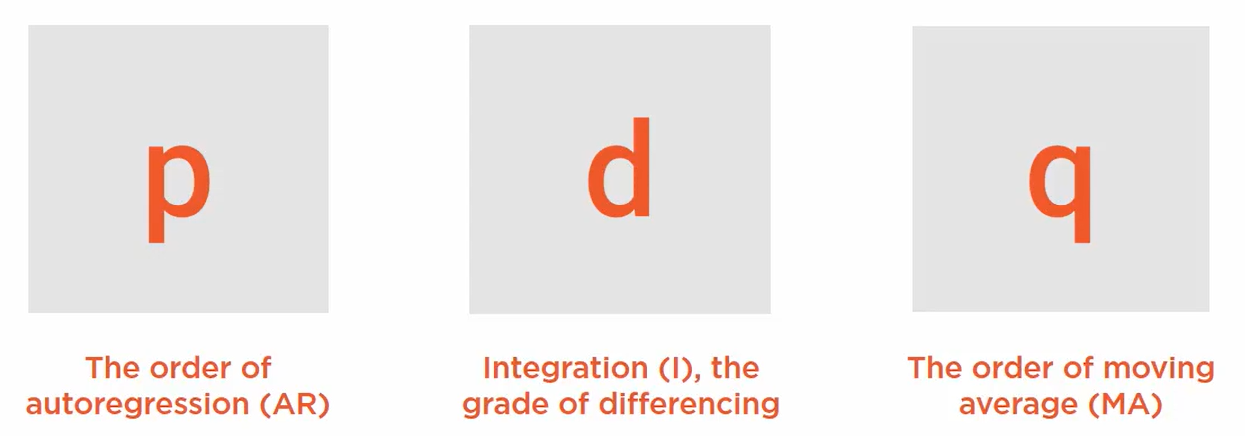

Let’s understand the three parameters in ARIMA(p, d, q):

| Component | Name                    | Intuition                                                                             |
| --------- | ----------------------- | ------------------------------------------------------------------------------------- |
| `p`       | **AutoRegression (AR)** | Uses **past values** to predict the future. Like linear regression on lagged data.    |
| `d`       | **Integrated (I)**      | Represents the number of **times the data needs differencing** to make it stationary. |
| `q`       | **Moving Average (MA)** | Uses **past errors** (residuals) to improve predictions. Think of smoothing noise.    |
<hr>

**📈 When to Use ARIMA?**

Use ARIMA when:

* You have univariate time series.
* Data is or can be made stationary (constant mean/variance).
* There is no strong seasonality (for that, use SARIMA).

<hr>

**🔍 How ARIMA Works**

Let’s say you have a time series y[t]. **ARIMA(1,1,1)** does this:

<pre>
# Differencing once (d=1)
dy[t] = y[t] - y[t-1]

# Then models:
dy[t] =  a * dy[t-1]        # AR(1) part, dy[t-1] is the lagged differenced value (AR term),
       + b * e[t-1]         # MA(1) part, e[t-1] is the previous error (MA term),
       + e[t]               # current white noise (error)

# So the model output prediction at time t is:  
ŷ[t] = y[t-1] + a * dy[t-1] + b * e[t-1]

# And the error term is:
e[t] = y[t] - ŷ[t]
</pre>
* The MA part uses past errors (e[t-1]) to improve current prediction.
* If residuals are white noise (uncorrelated and random), the model is good.


Where:
* a and b are learned coefficients.

## Dataset

In [1]:
!ls ../input/dataset/dataset.txt

../input/dataset/dataset.txt


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv('../input/dataset/dataset.txt', parse_dates=['date'], index_col='date')
df.rename(columns={col : col.strip() for col in df.columns}, inplace=True)
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


<Axes: xlabel='date'>

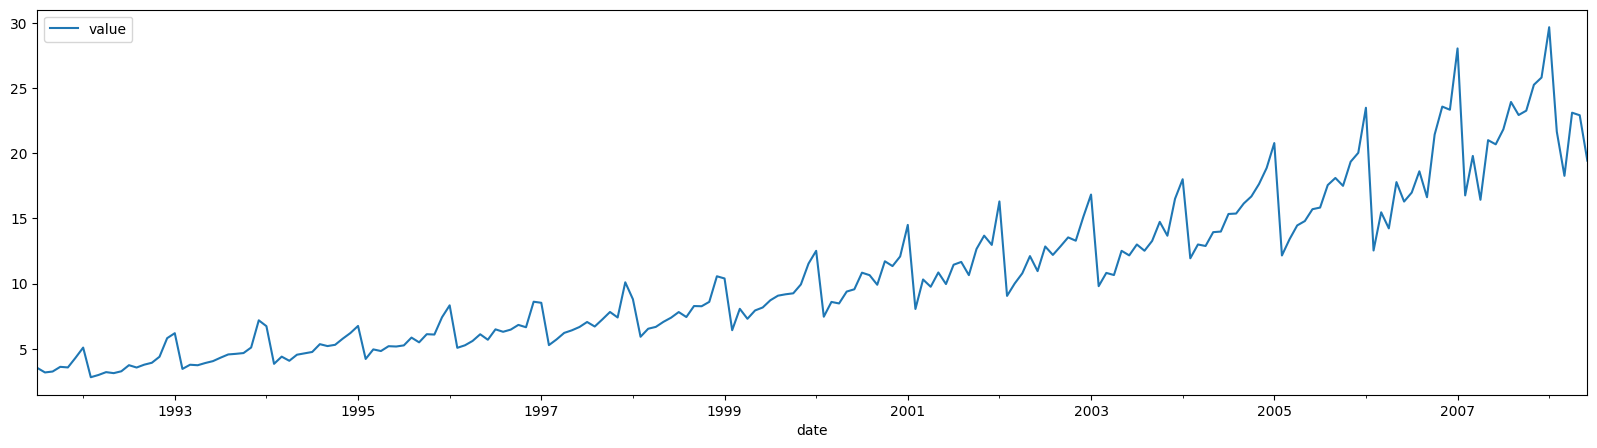

In [3]:
df.plot(figsize=(20, 5))

## Prerequisites

Before running ARIMA, ensure all prerequisites are completed

1. timeseries should be stationary
2. timeseries should be autocorrelated

<span style="background-color: yellow; font-style: italic;"> Note: Please refer timeseries_preliminary_tests.ipynb for more details</span>


### Parameter selection process

1. Stationarity test with augumented Dickey-Fuller test (d)
2. Tests for autocorrelation with ACF (q) and PCAF (p) plots
3. Model improvement with residual diagnostics

## Check for stationary - Finding Param d value for ARIMA

In [4]:
from statsmodels.tsa.stattools import adfuller

def is_ts_stationary(series):
    result = adfuller(series.dropna())
    statistic, p_val, num_lags, num_observation = result[0:4]
    statistic, p_val, num_lags, num_observation
    
    print(f"p_val: {p_val:.10f}") 
    return p_val < 0.05

is_ts_stationary(df)

p_val: 1.0000000000


False

Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

Lets try different order differencing

In [5]:
print("============ 1st order differencing ======================")
print(is_ts_stationary(df.value.diff()))
print("============ 2nd order differencing ======================")
print(is_ts_stationary(df.value.diff().diff()))

============ 1st order differencing ======================
p_val: 0.1166534169
False
============ 2nd order differencing ======================
p_val: 0.0000000000
True


As we can see 2nd order differencing did the trick.

<pre> d = 2   # This will be the value for ARIMA model </pre>

In [6]:
is_ts_stationary(df.value.diff().diff())

p_val: 0.0000000000


True

## Check for Autocorrelation - Finding Param p, q value for ARIMA

### ACF Plot - used for Moving Average q

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_chart(df, lags=10):
    fix, ax = plt.subplots(1, 1, figsize=(20, 5))
    plot_acf(df.dropna(), lags=lags, ax=ax)  # check up to 100 time lags
    plt.title("Autocorrelation Plot - ACF")
    plt.show()

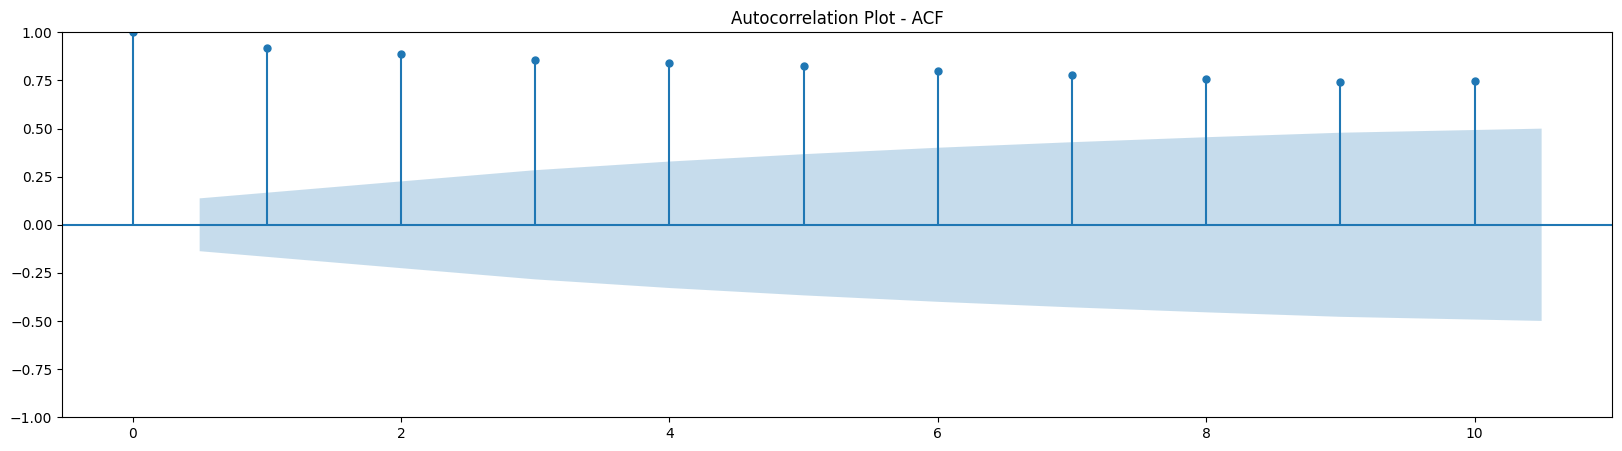

In [8]:
plot_acf_chart(df)

As we can see many lines are still outside blue region, meaning differencing is required

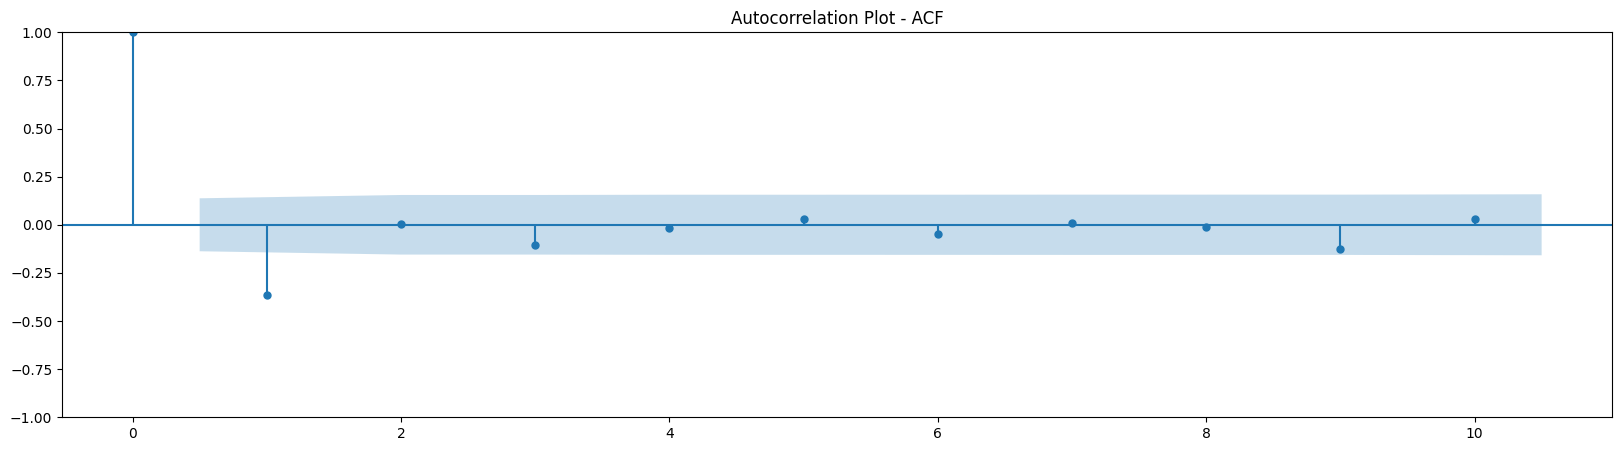

In [9]:
plot_acf_chart(df.diff().dropna())  # 1st differencing ACF plot

This looks good

<pre> q = 1</pre>

### PACF Plot - used for AutoRegression p

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_pacf_chart(df, lags=10):
    fix, ax = plt.subplots(1, 1, figsize=(20, 5))
    plot_pacf(df.dropna(), lags=10, ax=ax)  # check up to 100 time lags
    plt.title("Autocorrelation Plot - PACF")
    plt.show()

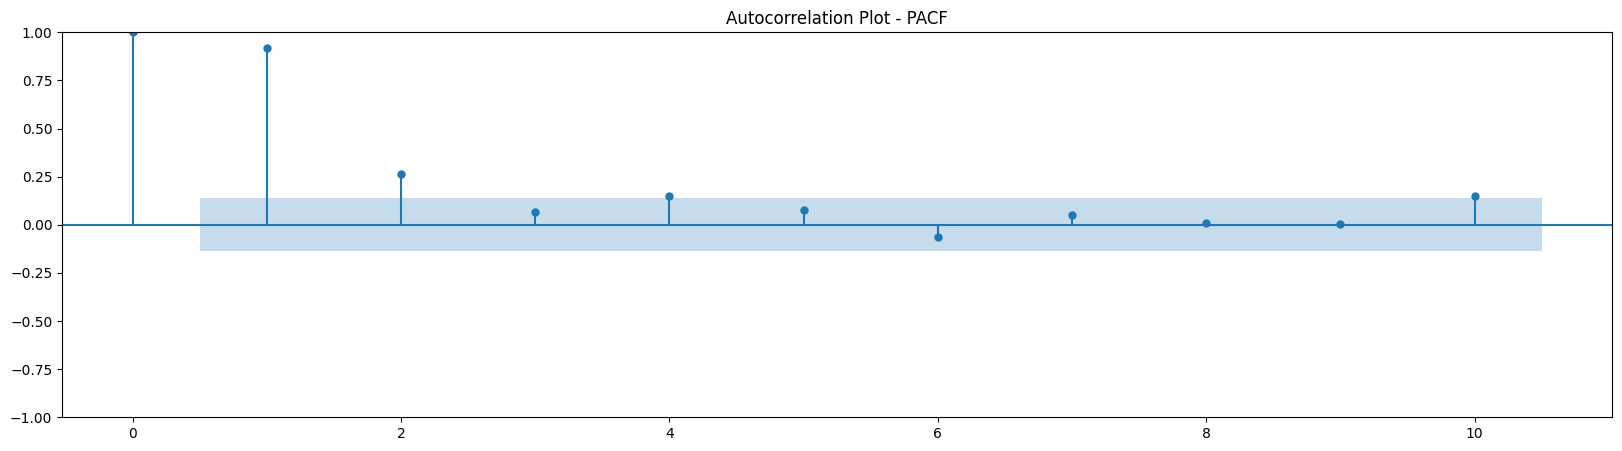

In [11]:
plot_pacf_chart(df)

As we can see many lines are still outside blue region, meaning differencing is required

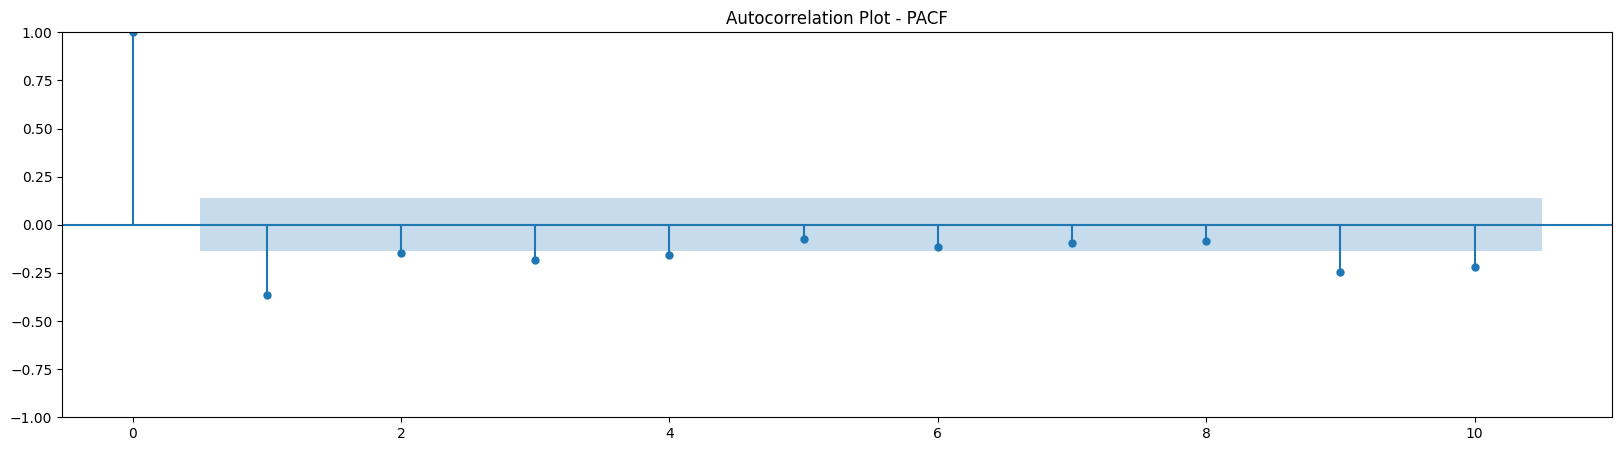

In [12]:
plot_pacf_chart(df.diff().dropna())  # 1st order differencing

We can see that couple of lags are well above the significance line. Also In Original PACF plot, value at 1 is significant and outside blue interval, so lets take it. 


<pre> p = 1 </pre>

## Lets fit model

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -438.108
Date:                Wed, 30 Jul 2025   AIC                            882.216
Time:                        11:10:26   BIC                            892.141
Sample:                    07-01-1991   HQIC                           886.232
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3649      0.054     -6.778      0.000      -0.470      -0.259
ma.L1         -0.9999      2.791     -0.358      0.720      -6.470       4.470
sigma2         4.3486     12.290      0.354      0.7

P>|z| for ma.L1 is still high, lets rerun with different param

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -424.762
Date:                Wed, 30 Jul 2025   AIC                            855.524
Time:                        11:10:26   BIC                            865.463
Sample:                    07-01-1991   HQIC                           859.545
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3009      0.094      3.195      0.001       0.116       0.485
ma.L1         -0.8300      0.048    -17.204      0.000      -0.925      -0.735
sigma2         3.8327      0.259     14.790      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


* The model AIC has slightly reduced, which is good. 
* The p-values of the AR and MA terms have improved and are highly significant (<< 0.05).

## Model improvement Residual Diagnostics

* Plot residual - to ensure constant mean and variance
* The Assumption is that their should be no autocorrelation between residual, all patters is already extracted by Arima Model
* Residuals should be normally distributed


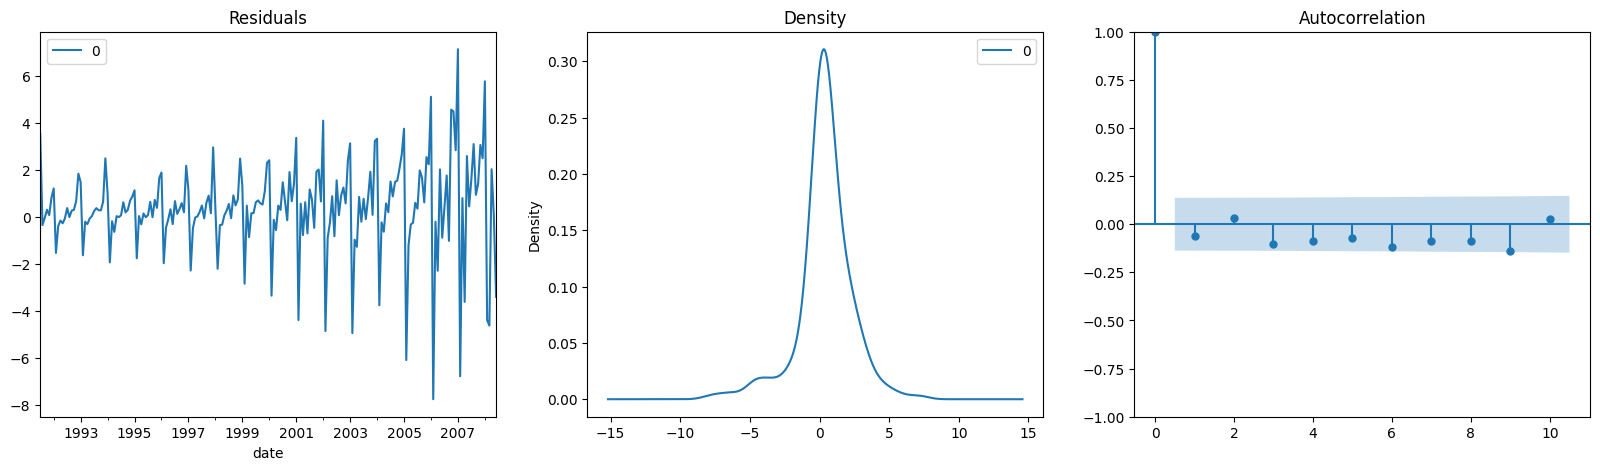

In [15]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fix, ax = plt.subplots(1, 3, figsize=(20, 5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plot_acf(residuals.dropna(), lags=10, ax=ax[2])

plt.show()

* The residual errors seem fine with near zero mean and uniform variance.
* From Autocorrelation chart we can see their is no autocorrelation among residuals as none of the points are outside blue zone


## Lets forecast

In [16]:
series_predict = model_fit.predict(start=len(df) - 40, end=len(df) + 100)
series_predict.head()

2005-03-01    14.610638
2005-04-01    14.780677
2005-05-01    15.044022
2005-06-01    15.102759
2005-07-01    15.479049
Freq: MS, Name: predicted_mean, dtype: float64

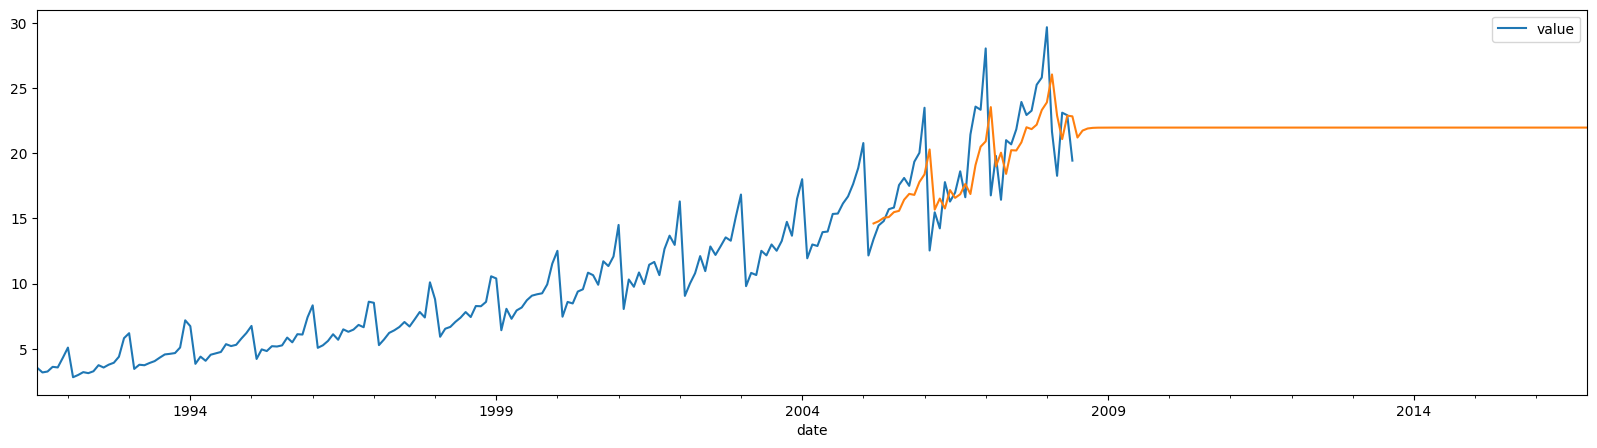

In [17]:
ax = df.plot(figsize=(20, 5))
series_predict.plot(ax=ax)
plt.show()

<span style="background-color: orange; font-style: italic;">Predictions are not good, Lets try to improve</span>

## Auto ARIMA

Now istead of manually trying to obtain param, lets algorithm obtain it automatically

In [18]:
!pip install -q pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00


In [19]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd', default=’kpss’
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series, 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0,              # The order of the seasonal differencing
                      trace=True,       # Whether to print status on the fit
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True # Whether to use the stepwise algorithm to identify the optimal model parameters.
        )

model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=0.41 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.870, Time=0.58 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  204
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -423.146
Date:                Wed, 30 Jul 2025   AIC                            858.292
Time:                        11:10:39   BIC                            878.201
Sample:                    07-01-1991   HQIC                           866.345
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3669      0.104      3.536      0.000       0.164       0.570
ar.L2          0.9964      0.038     26.255      0.000       0.922       1.071
ar.L3         -0.3639      0.090     -4.048      0.000      -0.540      -0.188
ma.L1          0.1395      0.089      1.565      0.118      -0.035       0.314
ma.L2         -0.8205      0.070    -11.737      0.000      -0.957      -0.683
sigma2         3.6034      0.310     11.641      0.000       2.997       4.210
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               119.31
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               9.49   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

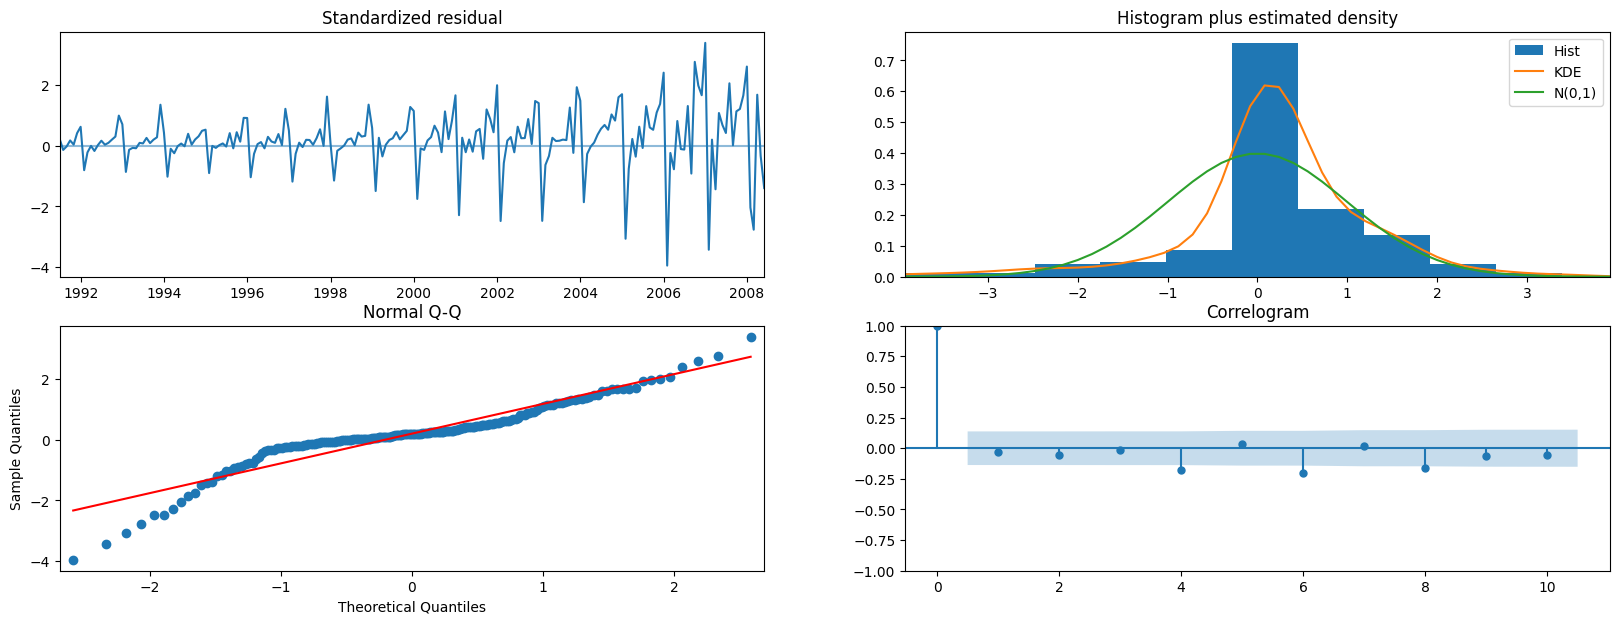

In [20]:
model.plot_diagnostics(figsize=(20,7))
plt.show()

## Interpretation of plots in plot diagnostics

* **Standardized residual:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

* **Histogram:** The density plot suggest normal distribution with mean slighlty shifted towards right.

* **Theoretical Quantiles:** Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

* **Correlogram:** The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

Overall, the model seems to be a good fit. So, let's use it to forecast.



## Lets forecast

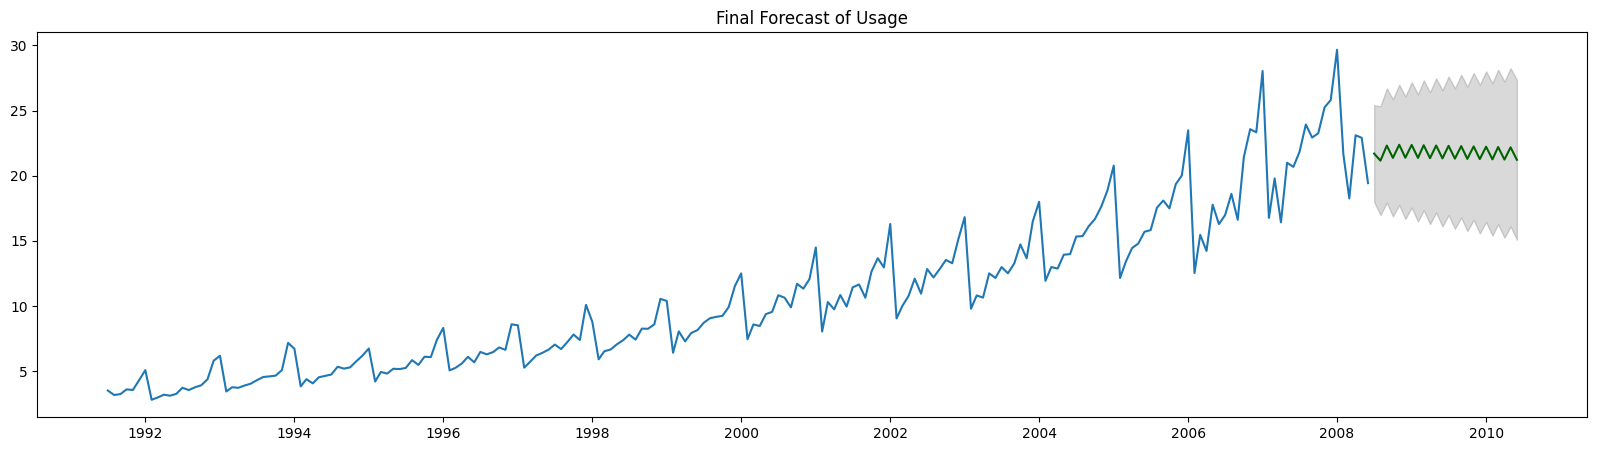

In [21]:
import numpy as np

n_periods = 24
series_predict, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_prediction = np.arange(len(df), len(df) + n_periods)

# make series for plotting purpose
lower_series = pd.Series(confint[:, 0], index=series_predict.index)
upper_series = pd.Series(confint[:, 1], index=series_predict.index)


# Plot
plt.figure(figsize=(20, 5))
plt.plot(df)
plt.plot(series_predict, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

<span style="background-color: orange; font-style: italic;">Predictions are still not good, Lets try to improve</span>

## SARIMA 

* The plain ARIMA model has a problem. It does not support seasonality.
* If the time series has defined seasonality, then we should go for Seasonal ARIMA model (in short SARIMA) which uses seasonal differencing.
* Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.
* So, the model will be represented as **SARIMA(p,d,q)x(P,D,Q)**, where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series. If the model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.
* We should set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. We should try to keep only either SAR or SMA terms if the model has seasonal components.


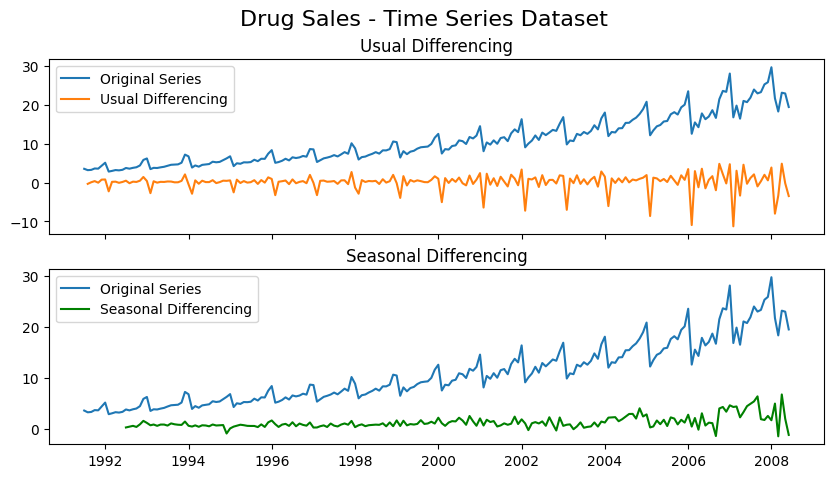

In [22]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df, label='Original Series')
axes[0].plot(df.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(df, label='Original Series')
axes[1].plot(df.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales - Time Series Dataset', fontsize=16)
plt.show()

* We can see that, the seasonal spikes are intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

## Decomposing timeseries

Lets try to visualize different timeseries components

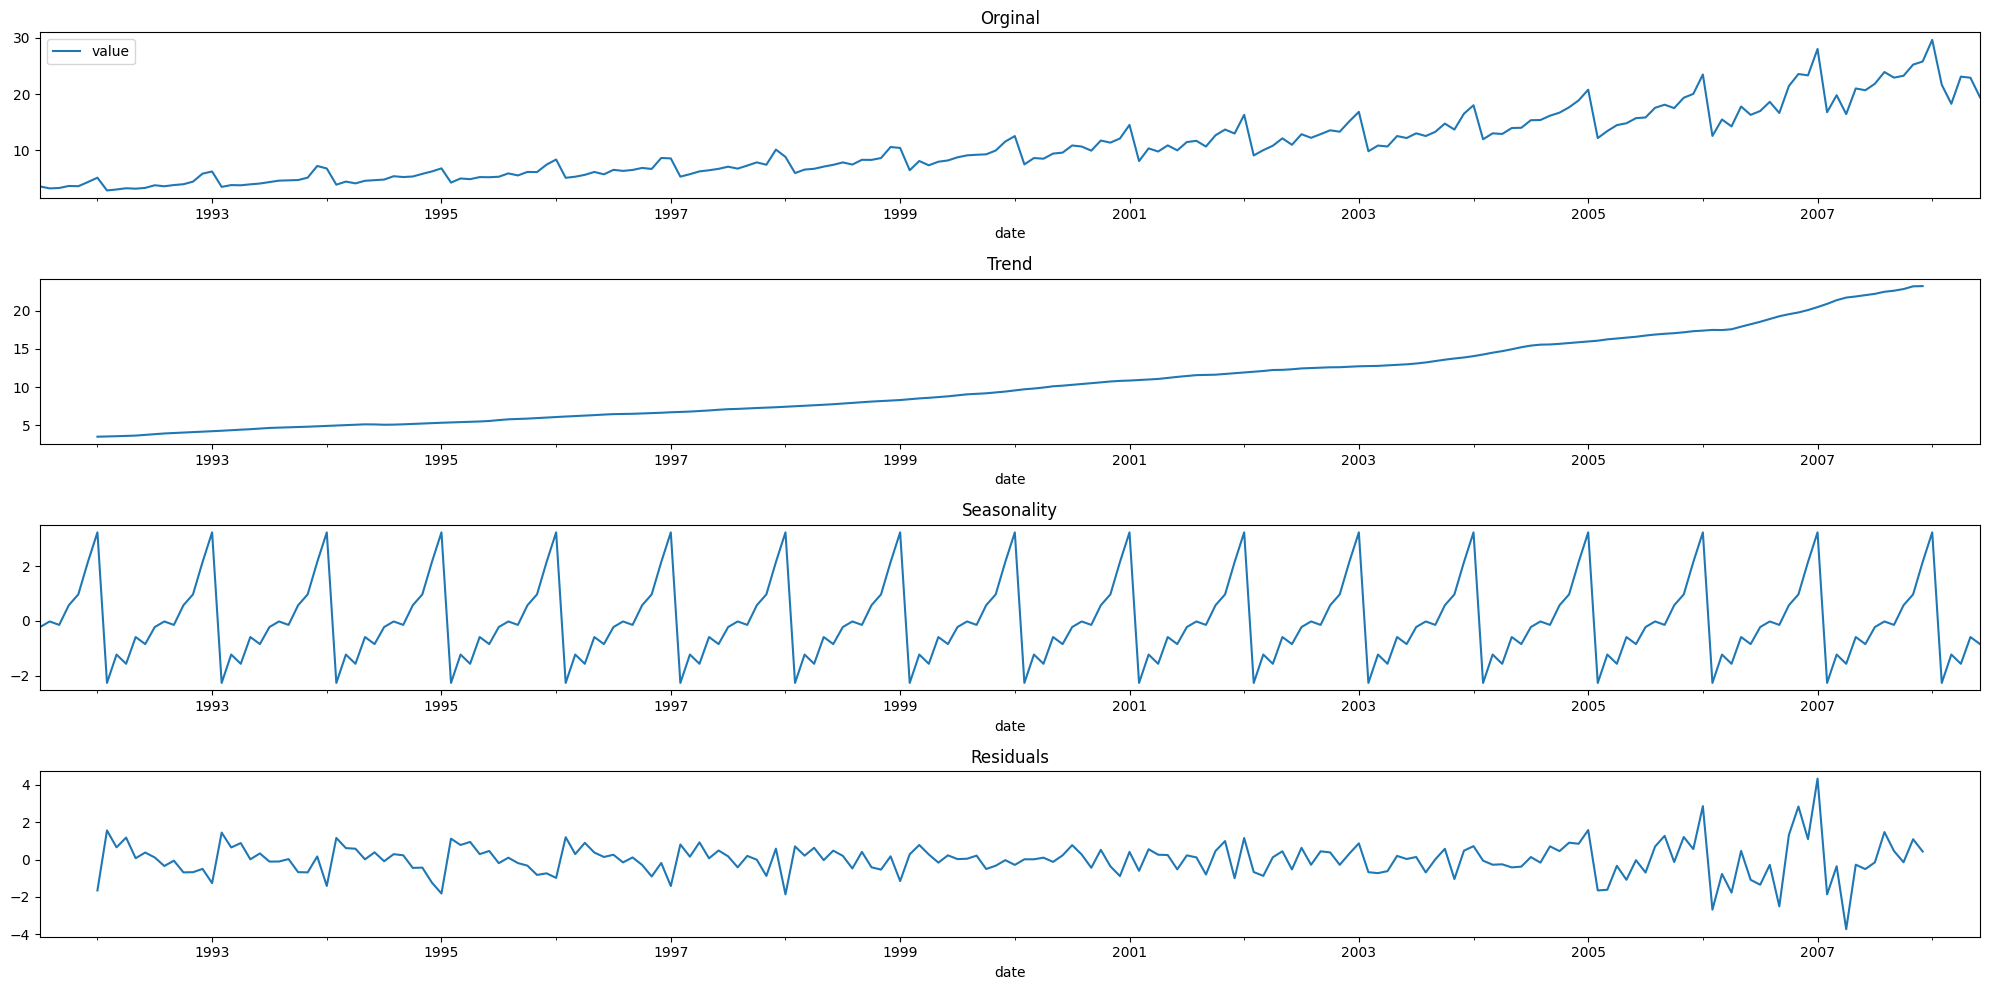

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_decompose = seasonal_decompose(df)

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
df.plot(ax=ax[0])
df_decompose.trend.plot(ax=ax[1])
df_decompose.seasonal.plot(ax=ax[2])
df_decompose.resid.plot(ax=ax[3])
ax[0].set_title('Orginal')
ax[1].set_title('Trend')
ax[2].set_title('Seasonality')
ax[3].set_title('Residuals')
plt.tight_layout()

We can clearly see seasonality in dataset

## Lets fit model

In [24]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True) 
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.28 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=3.18 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.08 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.477, Time=4.27 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.31 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.06 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.31 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  204
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -258.394
Date:                              Wed, 30 Jul 2025   AIC                            528.788
Time:                                      11:11:32   BIC                            548.333
Sample:                                  07-01-1991   HQIC                           536.704
                                       - 06-01-2008                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1638      0.097      1.696      0.090      -0.026       0.353
ar.L1          0.0960      0.043      2.228      0.026       0.012       0.180
ar.L2          0.4148      0.035     11.921      0.000       0.347       0.483
ar.L3          0.3510      0.054      6.546      0.000       0.246       0.456
ma.S.L12      -0.4627      0.058     -7.966      0.000      -0.577      -0.349
sigma2         0.8470      0.057     14.914      0.000       0.736       0.958
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               124.39
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              12.65   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Lets forecast

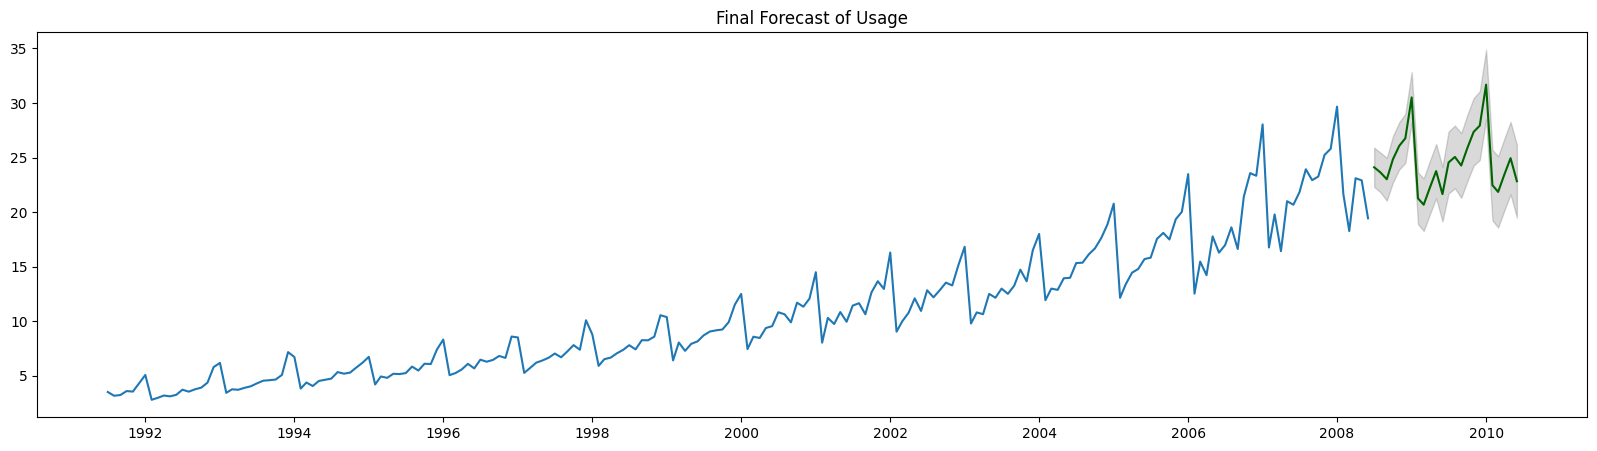

In [25]:
import numpy as np

n_periods = 24
series_predict, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_prediction = np.arange(len(df), len(df) + n_periods)

# make series for plotting purpose
lower_series = pd.Series(confint[:, 0], index=series_predict.index)
upper_series = pd.Series(confint[:, 1], index=series_predict.index)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(df)
plt.plot(series_predict, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series,
                 color='k', alpha=.15)
plt.title("Final Forecast of Usage")
plt.show()

<span style="background-color: lightgreen; font-style: italic;">Predictions are much better than earlier</span>

# References

* https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting/notebook#11.-Accuracy-Metrics-for-Time-Series-Forecast-
* https://app.pluralsight.com/library/courses/mining-data-time-series/table-of-contents